<a href="https://colab.research.google.com/github/miu0001/NweGit/blob/master/6.1%20Descriptive%20Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# == Equal-Width Histogram Utilities ==
# Uses: pandas, numpy, matplotlib (no seaborn)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Union

def _auto_bins(x: np.ndarray, method: str = "sturges") -> int:
    """
    Choose an automatic bin count.
    - 'sturges' (default): k = 1 + log2(n)
    - 'rice': k = 2 * n^(1/3)
    - 'fd': Freedman–Diaconis (k = range / h, where h = 2*IQR / n^(1/3))
    Returns at least 1.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return 1
    if method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    elif method == "fd":
        q75, q25 = np.percentile(x, [75, 25])
        iqr = q75 - q25
        if iqr <= 0:
            # Fallback if all/most values identical
            k = int(np.ceil(1 + np.log2(n)))
        else:
            h = 2 * iqr / (n ** (1/3))
            data_range = np.max(x) - np.min(x)
            k = int(np.ceil(max(1, data_range / h)))
    else:  # sturges
        k = int(np.ceil(1 + np.log2(n)))
    return max(1, k)

def _equal_width_edges(x: np.ndarray, k: int, start: Optional[float] = None, end: Optional[float] = None):
    """
    Build k equal-width bin edges covering [start, end] (defaults to data min/max).
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("No finite numeric data to bin.")
    if start is None: start = np.min(x)
    if end   is None: end   = np.max(x)
    if end <= start:
        # Expand a degenerate range slightly
        pad = 0.5 if start == end else 0
        start, end = start - pad, end + pad
    edges = np.linspace(start, end, k + 1)
    return edges

def equal_width_histogram(
    data: Union[pd.Series, pd.DataFrame, np.ndarray, list, str],
    column: Optional[Union[str, int]] = None,
    k: Optional[int] = None,
    auto_method: str = "sturges",
    start: Optional[float] = None,
    end: Optional[float] = None,
    title_prefix: str = "Histogram",
    xlabel: str = "Value",
    show_density: bool = True,
    show_counts: bool = True,
):
    """
    Build equal-width bins and plot:
      - Frequency histogram (counts)
      - Density histogram (area = 1)
    Returns: (freq_table DataFrame, edges ndarray)

    Parameters
    ----------
    data : pd.Series | pd.DataFrame | np.ndarray | list | str
        - If str: treated as a CSV URL/path and read with pandas.
        - If DataFrame: use `column` to select numeric column.
        - If Series/array/list: used directly.
    column : name or index of column to use (when data is a DataFrame or CSV).
    k : number of bins. If None, chosen automatically via `auto_method`.
    auto_method : 'sturges' (default), 'rice', or 'fd'
    start, end : optional numeric range for edges (defaults to data min/max).
    title_prefix, xlabel : plot labels.
    show_density, show_counts : whether to draw the two figures.
    """
    # --- 1) Load/Select the numeric series
    if isinstance(data, str):
        df = pd.read_csv(data)
        if column is None:
            # Pick first numeric column by default
            num_cols = df.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("No numeric columns found in the CSV.")
            series = df[num_cols[0]]
            column_used = num_cols[0]
        else:
            series = df[column]
            column_used = column
    elif isinstance(data, pd.DataFrame):
        if column is None:
            num_cols = data.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("No numeric columns in DataFrame.")
            series = data[num_cols[0]]
            column_used = num_cols[0]
        else:
            series = data[column]
            column_used = column
    elif isinstance(data, (pd.Series, np.ndarray, list)):
        series = pd.Series(data, dtype=float)
        column_used = "values"
    else:
        raise TypeError("Unsupported data type for 'data'.")

    x = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    if x.size == 0:
        raise ValueError("Selected column has no numeric (non-NaN) values.")

    # --- 2) Decide k and edges (equal width)
    if k is None:
        k = _auto_bins(x, method=auto_method)
    edges = _equal_width_edges(x, k, start=start, end=end)
    width = edges[1] - edges[0]

    # --- 3) Counts & relative frequencies
    counts, _ = np.histogram(x, bins=edges)
    n = x.size
    rel_freq = counts / n

    # Density heights so that bar area = rel. frequency (heights * width = rel_freq)
    density_heights = counts / (n * width)
    mids = 0.5 * (edges[:-1] + edges[1:])

    freq_table = pd.DataFrame({
        "bin": np.arange(1, k + 1),
        "lower_edge": edges[:-1],
        "upper_edge": edges[1:],
        "midpoint": mids,
        "width": width,
        "frequency": counts,
        "relative_frequency": rel_freq,
        "density_height": density_heights,
    })

    # --- 4) Plots (each on its own figure; no explicit colors)
    if show_counts:
        plt.figure()
        # Draw equal-width rectangles manually for full control
        plt.bar(mids, counts, width=width, align="center", edgecolor="black")
        plt.title(f"{title_prefix} (Counts) — {column_used}")
        plt.xlabel(xlabel)
        plt.ylabel("Frequency")
        plt.show()

    if show_density:
        plt.figure()
        plt.bar(mids, density_heights, width=width, align="center", edgecolor="black")
        plt.title(f"{title_prefix} (Density, area = 1) — {column_used}")
        plt.xlabel(xlabel)
        plt.ylabel("Density")
        plt.show()

        total_area = float(np.sum(density_heights * width))
        print(f"Check: total area (should be ~1) = {total_area:.6f}")

    return freq_table, edges


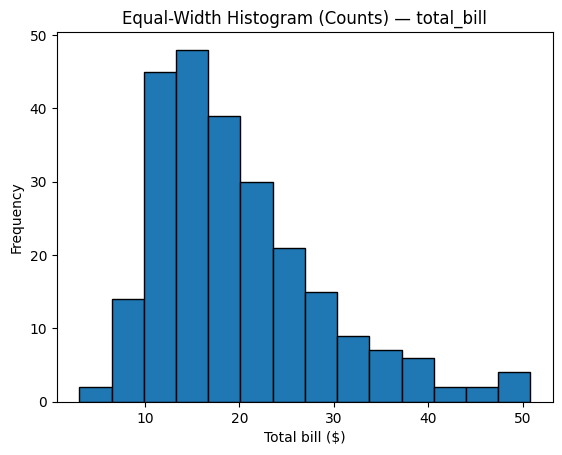

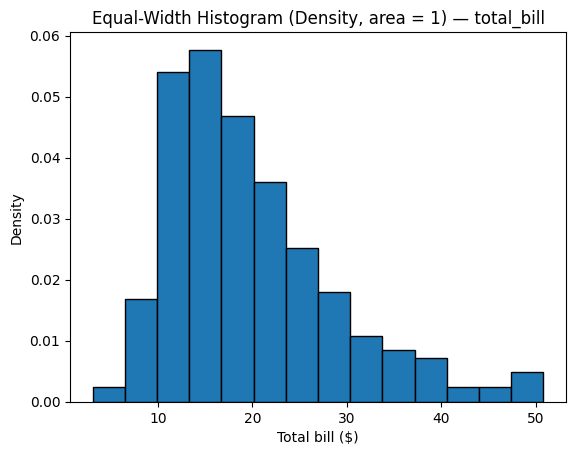

Check: total area (should be ~1) = 1.000000


,bin,lower_edge,upper_edge,midpoint,width,frequency,relative_frequency,density_height
0,1,3.0700,6.4800,4.7750,3.4100,2,0.0082,0.0024
1,2,6.4800,9.8900,8.1850,3.4100,14,0.0574,0.0168
2,3,9.8900,13.3000,11.5950,3.4100,45,0.1844,0.0541
3,4,13.3000,16.7100,15.0050,3.4100,48,0.1967,0.0577
4,5,16.7100,20.1200,18.4150,3.4100,39,0.1598,0.0469


In [20]:
# Example using a public CSV (replace with your URL + column)
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv"
table, edges = equal_width_histogram(
    data=url,
    column="total_bill",    # numeric column in the CSV
    k=None,                 # let it choose automatically (Sturges/Rice/FD via auto_method)
    auto_method="fd",       # 'sturges'|'rice'|'fd'
    title_prefix="Equal-Width Histogram",
    xlabel="Total bill ($)"
)
table.head()


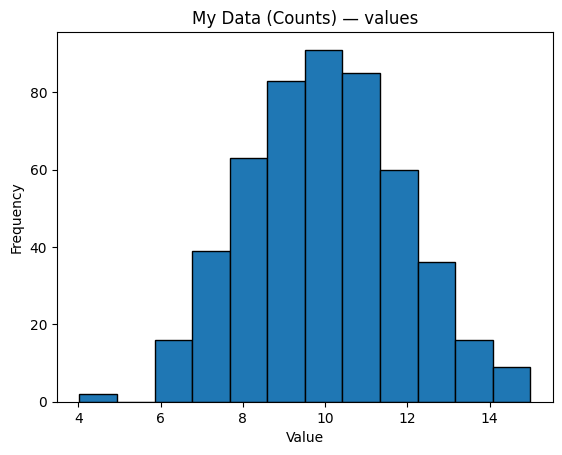

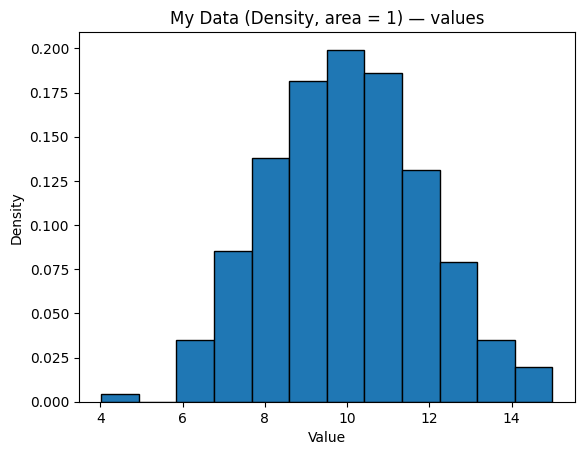

Check: total area (should be ~1) = 1.000000


,bin,lower_edge,upper_edge,midpoint,width,frequency,relative_frequency,density_height
0,1,4.0262,4.9398,4.4830,0.9136,2,0.0040,0.0044
1,2,4.9398,5.8534,5.3966,0.9136,0,0.0000,0.0000
2,3,5.8534,6.7670,6.3102,0.9136,16,0.0320,0.0350
3,4,6.7670,7.6806,7.2238,0.9136,39,0.0780,0.0854
4,5,7.6806,8.5942,8.1374,0.9136,63,0.1260,0.1379


In [21]:
# Local numeric data
arr = np.random.normal(10, 2, size=500)
table2, edges2 = equal_width_histogram(arr, k=12, title_prefix="My Data", xlabel="Value")
table2.head()


In [23]:
# Setup + loader (works with URL CSVs, local CSVs, Series, arrays)

from typing import Optional, Union

def _load_numeric_series(data: Union[str, pd.DataFrame, pd.Series, np.ndarray, list],
                         column: Optional[Union[str,int]]=None) -> pd.Series:
    """Return a numeric pandas Series from a URL/path/DataFrame/Series/array."""
    if isinstance(data, str):
        df = pd.read_csv(data)
        if column is None:
            num_cols = df.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("No numeric columns found in the CSV.")
            s = df[num_cols[0]]
        else:
            s = df[column]
    elif isinstance(data, pd.DataFrame):
        if column is None:
            num_cols = data.select_dtypes(include=[np.number]).columns
            if len(num_cols) == 0:
                raise ValueError("No numeric columns in DataFrame.")
            s = data[num_cols[0]]
        else:
            s = data[column]
    elif isinstance(data, (pd.Series, np.ndarray, list)):
        s = pd.Series(data, dtype=float)
    else:
        raise TypeError("Unsupported data type for 'data'.")
    return pd.to_numeric(s, errors="coerce").dropna()

In [24]:
# Relative-frequency histogram (equal width) + exponential pdf overlay

def _auto_bins(x: np.ndarray, method: str = "fd") -> int:
    """Choose k automatically: 'fd' (default), 'sturges', or 'rice'."""
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0: return 1
    if method == "sturges":
        k = int(np.ceil(1 + np.log2(n)))
    elif method == "rice":
        k = int(np.ceil(2 * n ** (1/3)))
    else:  # Freedman–Diaconis
        q75, q25 = np.percentile(x, [75, 25])
        iqr = q75 - q25
        if iqr <= 0:
            k = int(np.ceil(1 + np.log2(n)))
        else:
            h = 2 * iqr / (n ** (1/3))
            rng = np.max(x) - np.min(x)
            k = int(np.ceil(max(1, rng / max(h, 1e-12))))
    return max(1, k)

def hist_with_exponential_pdf(
    data: Union[str, pd.DataFrame, pd.Series, np.ndarray, list],
    column: Optional[Union[str,int]] = None,
    k: Optional[int] = None,
    auto_method: str = "fd",
    theta: Optional[float] = None,   # scale parameter θ; pdf=1/θ * exp(-x/θ)
    start: Optional[float] = None,
    end: Optional[float] = None,
    title: str = "Relative-Frequency Histogram with Exponential PDF",
    xlabel: str = "x",
):
    # 1) Load numeric series
    s = _load_numeric_series(data, column)
    x = s.to_numpy()
    x = x[np.isfinite(x)]
    if x.size == 0:
        raise ValueError("No numeric data after cleaning.")
    if theta is None:
        theta = float(np.mean(x))  # MLE for exponential scale

    # 2) Equal-width bins
    if k is None:
        k = _auto_bins(x, method=auto_method)
    if start is None: start = float(np.min(x))
    if end   is None: end   = float(np.max(x))
    if end <= start:
        end = start + 1.0
    edges = np.linspace(start, end, k + 1)
    width = edges[1] - edges[0]
    mids = 0.5 * (edges[:-1] + edges[1:])

    # 3) Relative frequencies and density heights (area = 1)
    counts, _ = np.histogram(x, bins=edges)
    n = x.size
    rel = counts / n
    density_heights = counts / (n * width)

    # 4) Plot relative-frequency histogram (bars are heights=relative frequency)
    plt.figure()
    plt.bar(mids, rel, width=width, align="center", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Relative frequency")

    # 5) Overlay exponential pdf (convert pdf to same y-scale as density to compare shapes)
    # Here we overlay the pdf as a *density* curve; it is comparable to a density histogram.
    grid = np.linspace(max(0.0, start), end, 400)  # exponential is defined for x>=0
    pdf = (1.0/theta) * np.exp(-grid/theta)
    # Convert density to relative-frequency scale by multiplying by bin width
    # so its "height" is comparable to the relative-frequency bars.
    plt.plot(grid, pdf * width)  # no explicit color
    plt.show()

    # For reference, print area check for the density histogram:
    total_area = float(np.sum(density_heights * width))
    print(f"Check (density histogram area): {total_area:.6f} (should be ~1)")
    print(f"Used θ (scale) = {theta:.6g}")

    # Return a tidy table
    table = pd.DataFrame({
        "bin": np.arange(1, k+1),
        "lower_edge": edges[:-1],
        "upper_edge": edges[1:],
        "midpoint": mids,
        "width": width,
        "frequency": counts,
        "relative_frequency": rel,
        "density_height": density_heights
    })
    return table, edges, theta


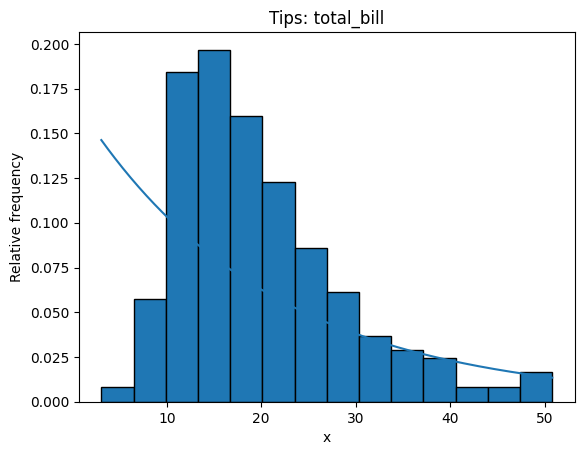

Check (density histogram area): 1.000000 (should be ~1)
Used θ (scale) = 20


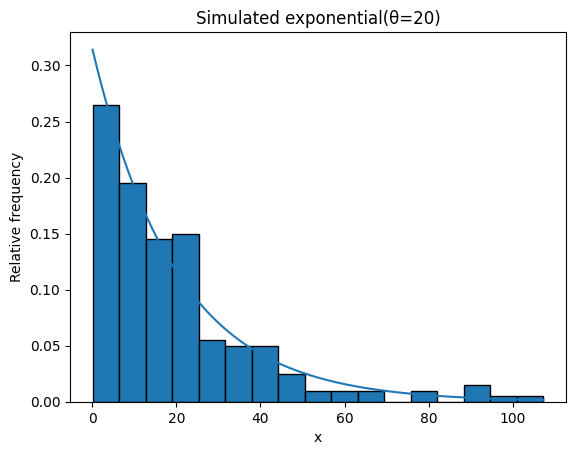

Check (density histogram area): 1.000000 (should be ~1)
Used θ (scale) = 20


In [25]:
# Usage examples

# A) From a URL CSV (replace with your data + numeric column)
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv"
table, edges, theta_used = hist_with_exponential_pdf(url, column="total_bill", theta=20, title="Tips: total_bill")

# B) From a local array
arr = np.random.exponential(scale=20, size=200)
table2, edges2, theta2 = hist_with_exponential_pdf(arr, theta=20, title="Simulated exponential(θ=20)")


In [26]:
def ecdf_vs_exponential_cdf(
    data: Union[str, pd.DataFrame, pd.Series, np.ndarray, list],
    column: Optional[Union[str,int]] = None,
    theta: Optional[float] = None,
    title: str = "Empirical CDF with Theoretical Exponential CDF",
    xlabel: str = "x",
):
    # 1) Load numeric data
    s = _load_numeric_series(data, column)
    x = np.sort(s.to_numpy())
    n = x.size
    if n == 0:
        raise ValueError("No numeric data.")
    if theta is None:
        theta = float(np.mean(x))  # MLE

    # 2) Empirical CDF: step function with jumps of size 1/n at each observation
    y = np.arange(1, n+1) / n

    plt.figure()
    plt.step(x, y, where="post", label="Empirical CDF")  # step function

    # 3) Theoretical exponential CDF: F(x) = 1 - exp(-x/theta)
    grid = np.linspace(max(0.0, x.min()), x.max(), 400)
    F_theory = 1.0 - np.exp(-grid/theta)
    plt.plot(grid, F_theory, label="Theoretical CDF (exp)")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("CDF")
    plt.legend()
    plt.show()

    print(f"Used θ (scale) = {theta:.6g}")


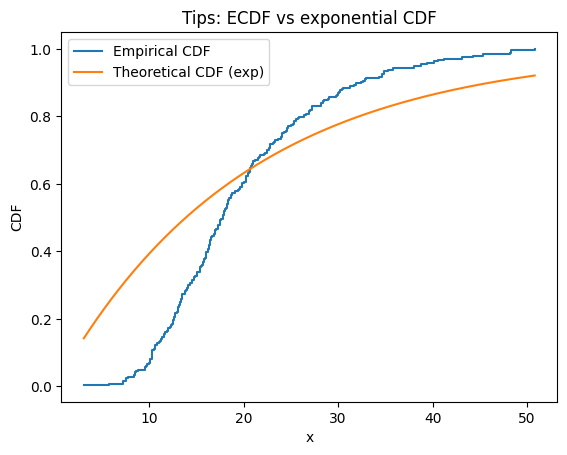

Used θ (scale) = 20


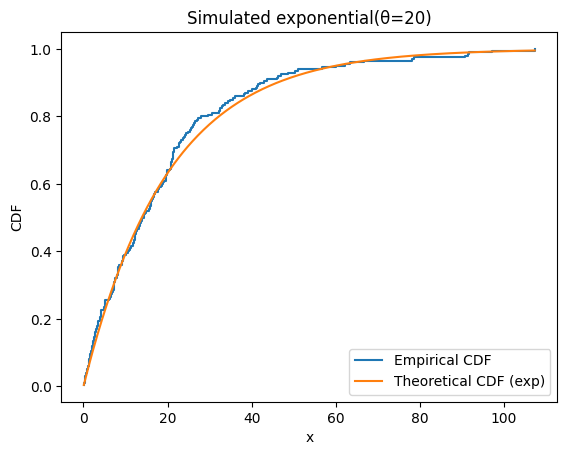

Used θ (scale) = 20


In [27]:
# A) URL CSV
ecdf_vs_exponential_cdf(url, column="total_bill", theta=20, title="Tips: ECDF vs exponential CDF")

# B) Local array (same arr from above)
ecdf_vs_exponential_cdf(arr, theta=20, title="Simulated exponential(θ=20)")
